In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [8]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [17]:
base_skin_dir = os.path.join('F:\\', 'F:\\Skin Cancer')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [18]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [19]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  F:\Skin Cancer\HAM10000_images_part_1\ISIC_002...   
1  F:\Skin Cancer\HAM10000_images_part_1\ISIC_002...   
2  F:\Skin Cancer\HAM10000_images_part_1\ISIC_002...   
3  F:\Skin Cancer\HAM10000_images_part_1\ISIC_002...   
4  F:\Skin Cancer\HAM10000_images_part_2\ISIC_003...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

In [20]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [21]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [22]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [23]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


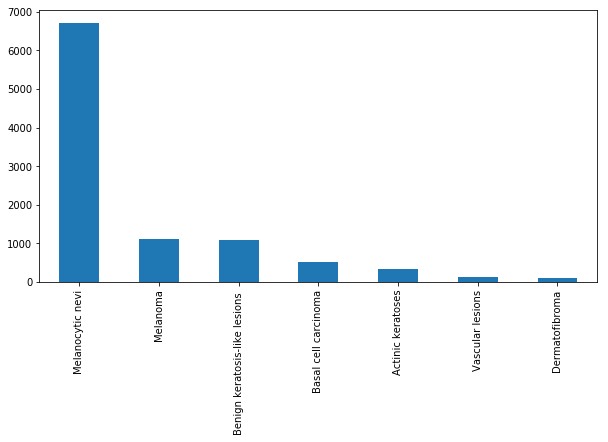

In [29]:
fig, ax1 = plt.subplots(1,1, figsize = (10,5))
skin_df['cell_type'].value_counts().plot(kind='bar')

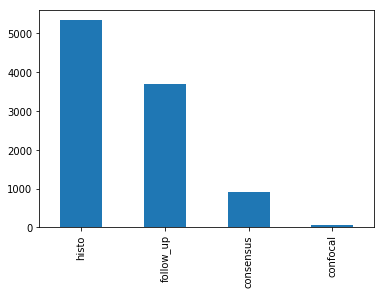

In [30]:
skin_df['dx_type'].value_counts().plot(kind='bar')

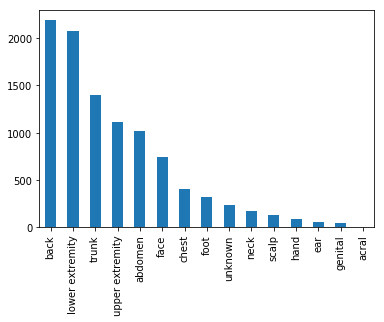

In [32]:
skin_df['localization'].value_counts().plot(kind='bar')

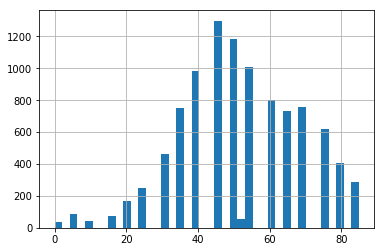

In [35]:
skin_df['age'].hist(bins=40)

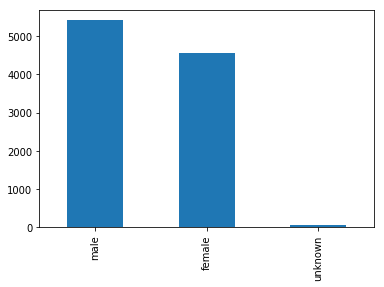

In [45]:
skin_df['sex'].value_counts().plot(kind='bar')

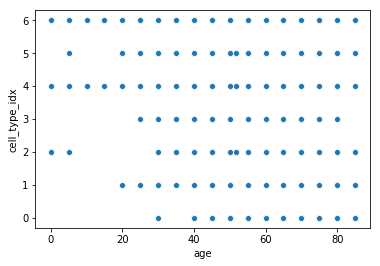

In [46]:
sns.scatterplot('age','cell_type_idx',data=skin_df)

D:\Programs\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


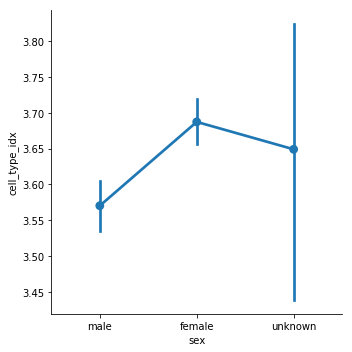

In [47]:
sns.factorplot('sex','cell_type_idx',data=skin_df)

In [48]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [49]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  F:\Skin Cancer\HAM10000_images_part_1\ISIC_002...   
1  F:\Skin Cancer\HAM10000_images_part_1\ISIC_002...   
2  F:\Skin Cancer\HAM10000_images_part_1\ISIC_002...   
3  F:\Skin Cancer\HAM10000_images_part_1\ISIC_002...   
4  F:\Skin Cancer\HAM10000_images_part_2\ISIC_003...   

                        cell_type  cell_type_idx  \
0  Benign keratosis-like lesions               2   
1  Benign keratosis-like lesions               2   
2  Benign keratosis-like lesions               2   
3  Benign keratosis-like lesions               2   
4  Benign keratosis-like lesions               2   

                                               image  
0  [[[191, 153, 194], [191, 154, 198], [189, 152,...  
1  [[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3...  
2  [[[186, 126, 136], [190, 136, 149], [195, 137,...  
3  [[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6...  
4  [[[136, 91, 114], [148, 104, 127], [161, 117, ...

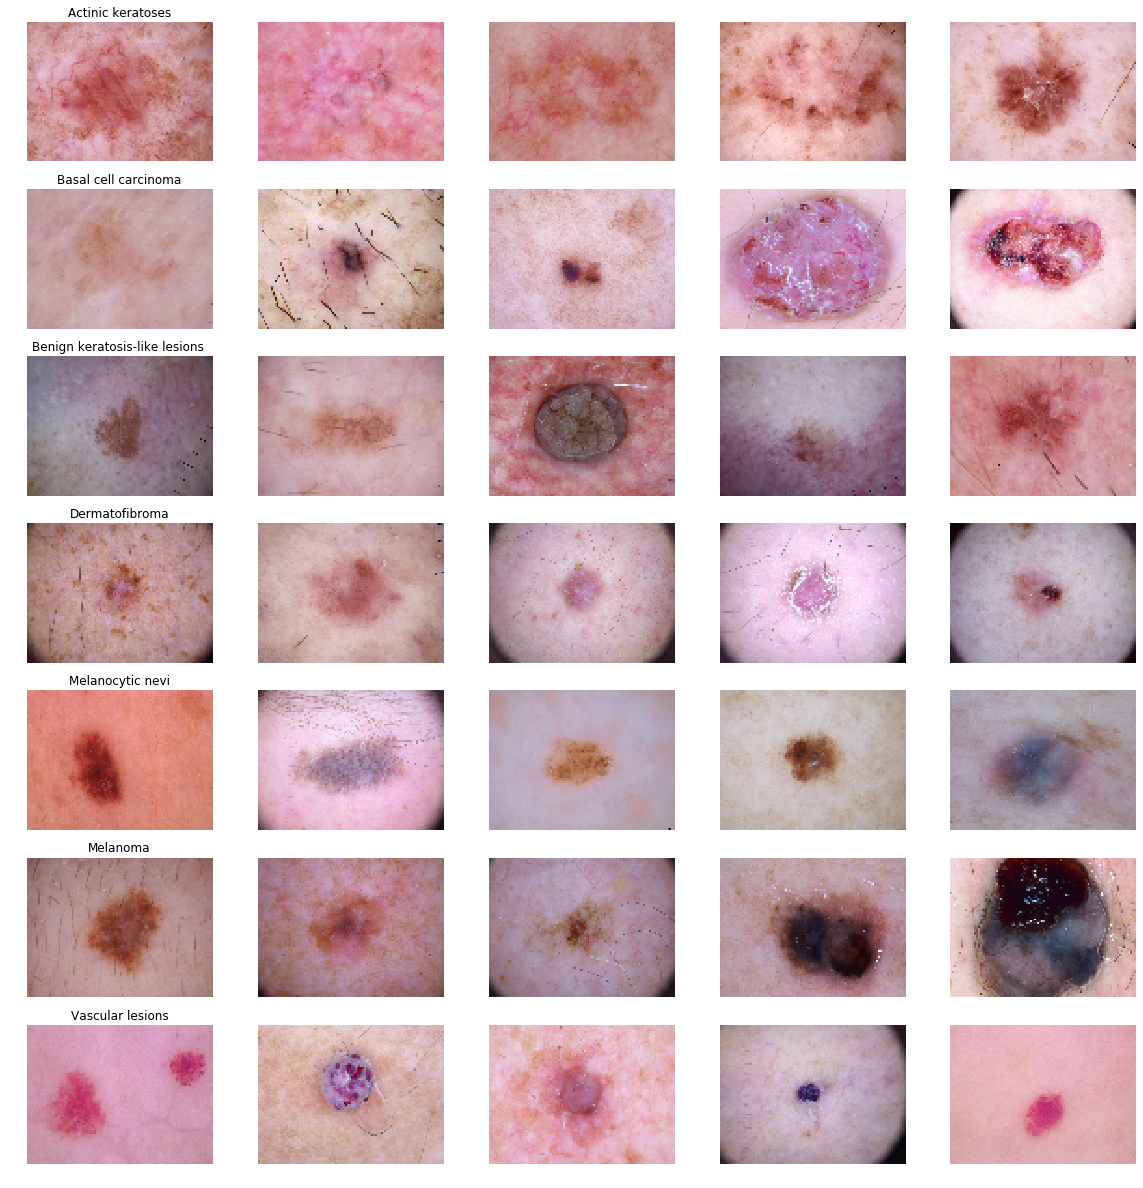

In [50]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [51]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [53]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [54]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [55]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [56]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [57]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [58]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [59]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

W1113 00:29:56.971294 14640 deprecation_wrapper.py:119] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1113 00:29:57.614068 14640 deprecation_wrapper.py:119] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1113 00:29:57.683517 14640 deprecation_wrapper.py:119] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1113 00:29:57.864626 14640 deprecation_wrapper.py:119] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1113 00:29:57.867586 14640 deprecation_wrapper.py:119] From D:\Programs\Anaconda3\lib\site

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 64)        0         
__________

In [61]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [62]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

W1113 00:54:03.414825 14640 deprecation_wrapper.py:119] From D:\Programs\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1113 00:54:03.420809 14640 deprecation_wrapper.py:119] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [63]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [64]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [65]:
# Fit the model
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

W1113 01:00:59.524559 14640 deprecation.py:323] From D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
721/721 [==============================] - 107s 148ms/step - loss: 1.0185 - acc: 0.6664 - val_loss: 0.8886 - val_acc: 0.6845
Epoch 2/50
721/721 [==============================] - 107s 148ms/step - loss: 0.9099 - acc: 0.6742 - val_loss: 0.8231 - val_acc: 0.6883
Epoch 3/50
721/721 [==============================] - 109s 151ms/step - loss: 0.8811 - acc: 0.6795 - val_loss: 0.8243 - val_acc: 0.6808
Epoch 4/50
721/721 [==============================] - 115s 159ms/step - loss: 0.8386 - acc: 0.6942 - val_loss: 0.8049 - val_acc: 0.7045
Epoch 5/50
721/721 [==============================] - 114s 158ms/step - loss: 0.8240 - acc: 0.6971 - val_loss: 0.7870 - val_acc: 0.7120
Epoch 6/50
721/721 [==============================] - 119s 164ms/step - loss: 0.8176 - acc: 0.6981 - val_loss: 0.7882 - val_acc: 0.7382
Epoch 7/50
721/721 [==============================] - 126s 174ms/step - loss: 0.7800 - acc: 0.7137 - val_loss: 0.7639 - val_acc: 0.7419
Epoch 8/50
721/721 [============================

In [66]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

802/802 [==============================] - 2s 2ms/step
Validation: accuracy = 0.775561  ;  loss_v = 0.627497
Test: accuracy = 0.764353  ;  loss = 0.619907


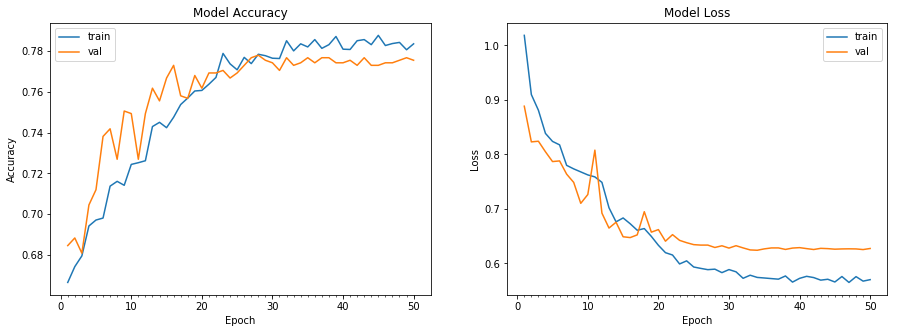

In [67]:
plot_model_history(history)

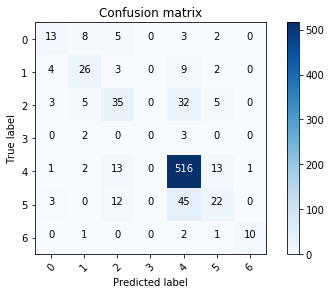

In [68]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

Text(0, 0.5, 'Fraction classified incorrectly')

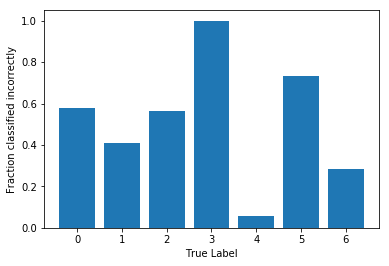

In [69]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')